# Set UP Notebook

In [1]:
import os
os.chdir('/home/tzd/Hg_dataset_practice/Analysis_of_ASGM_Emissions_in_Peru')

In [2]:
%matplotlib inline
#import needed modules to plot data
import numpy as np
import pandas as pd
import csv
import xarray as xr
import datetime
from scipy import stats
import cartopy.crs as ccrs
from gamap_colormap import WhGrYlRd  # import the "WhGrYlRd" variable from my custom Python script
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import ScalarFormatter,AutoMinorLocator 
plt.style.use(
    "https://github.com/aeturrell/coding-for-economists/raw/main/plot_style.txt"
)
mpl.rcParams.update({"lines.linewidth": 1.2})
plot_colors={'Base (ASGM = ON)':'b','Base (ASGM = OFF)':'#329932','Observations':'#ff6961'}
np.seterr(invalid='ignore'); # disable a warning from matplotlib and cartopy


# Ari's Code to get no asgm model output

In [3]:
"""
Created on Fri May  7 14:24:42 2021
Extract Hg0 at model grid boxes for comparison with observations
@author: arifeinberg
"""
#%%
import os
from os import path
from scipy import stats

#%%
os.chdir('/net/fs03/d0/arifein/python/')
#%%
def get_model_ts(site_str): # get model time series
    # first check if site files exist
    pn1 = '../GEOS-Chem_runs/run0003/OutputDir/' # path of BASE simulation
    pn2 = '../GEOS-Chem_runs/run0004/OutputDir/' # path of ASGM simulation
    fn = 'GEOSChem.SpeciesConc' + site_str + '.alltime_d.nc4' # time series at site
    
    bool_exists = path.exists(pn1 + fn) # boolean to check if exists
    if not bool_exists :
        print('Error with filename or site string incorrect')
        return
    
    # continue with extracting model data
    ds1 = xr.open_dataset(pn1 + fn) # BASE simulation
    ds2 = xr.open_dataset(pn2 + fn) # ASGM simulation
    
    if site_str == 'CHC' : # CHC altitude is close to GEOS-Chem level 20
        # BASE
        Hg0 = ds1.SpeciesConc_Hg0.isel(lev = 19).squeeze() # subset for level
        # ASGM        
        Hg0_ASGM = ds2.SpeciesConc_Hg0.isel(lev = 19).squeeze() # subset for level
    elif site_str == 'TIT' : # TIT altitude is close to GEOS-Chem level 15
        # BASE
        Hg0 = ds1.SpeciesConc_Hg0.isel(lev = 14).squeeze() # subset for level
        # ASGM    
        Hg0_ASGM = ds2.SpeciesConc_Hg0.isel(lev = 14).squeeze() # subset for level            
    else : # assume that all other sites are at the surface
        # BASE
        Hg0 = ds1.SpeciesConc_Hg0.isel(lev = 0).squeeze()
        # ASGM        
        Hg0_ASGM = ds2.SpeciesConc_Hg0.isel(lev = 0).squeeze() # subset for level
        
    # convert units to ng m^-3
    R = 8.314462 # m^3 Pa K^-1 mol ^-1
    MW_Hg = 200.59 # g mol^-1
    ng_g = 1e9 # ng/g
    
    stdpressure = 101325 # Pascals
    stdtemp = 273.15 # Kelvins
    
    unit_conv = stdpressure / R / stdtemp * MW_Hg * ng_g # converter from vmr to ng m^-3
    
    Hg0 = Hg0 * unit_conv
    Hg0_ASGM = Hg0_ASGM * unit_conv
    
    # calculate contribution from ASGM
    Hg0_c_ASGM = Hg0 - Hg0_ASGM # contribution from ASGM emissions
        
    # return both time series
    return Hg0_ASGM.to_dataframe()

# Upload Model Outputs

In [4]:
def get_model(region):
    
    if region == 'mdd':#Upload ATM Hg at Chacaltaya after 2x emission increase in Madre de Dios
        ds_modified= xr.open_dataset('/net/fs03/d1/tzd/RAworkflow/GCrun/2xMDD/merra2_2x25_Hg/OutputDir/GEOSChem.SpeciesConc.14_15output_levels.nc4')
        #print('The region provided is mdd')
        
    elif region == 'aqp':#Upload ATM Hg at Chacaltaya after 2x emission increase in Arequipa
        ds_modified=xr.open_dataset('/net/fs03/d1/tzd/RAworkflow/GCrun/aqp_updated/merra2_2x25_Hg/OutputDir/GEOSChem.SpeciesConc.14_15output_levels.nc4')
        #print('The region provided is aqp')

    elif region == 'spun':#Upload ATM Hg at Chacaltaya after 2x emission increase in South Puno
        ds_modified= xr.open_dataset('/net/fs03/d1/tzd/RAworkflow/GCrun/Puno/SouthPuno_C/merra2_2x25_Hg/OutputDir/GEOSChem.SpeciesConc.14_15output_levels.nc4')

    elif region == 'npun':#Upload ATM Hg at Chacaltaya after 2x emission increase in North Puno
        ds_modified=xr.open_dataset('/net/fs03/d1/tzd/RAworkflow/GCrun/Puno/merra2_2x25_Hg/OutputDir/GEOSChem.SpeciesConc.14_15output_levels.nc4')
    elif region == 'apr':#Upload ATM Hg at Chacaltaya after 2x emission increase in Apurímac
        ds_modified= xr.open_dataset('/net/fs03/d1/tzd/RAworkflow/GCrun/Apurimac/merra2_2x25_Hg/OutputDir/GEOSChem.SpeciesConc.14_15output_levels.nc4')
    else:
        print('The region provided is not in the inventory')
    
    #Extract Chalcataya Site
    Hg0_modified = ds_modified.SpeciesConc_Hg0
    Hg0_modified=Hg0_modified.where((Hg0_modified.lon==-67.5) & (Hg0_modified.lat==-16.0), drop=True)
        
    return Hg0_modified

In [5]:
def getLoRes():
    Hg0_Lres = xr.open_dataset('/net/fs03/d1/tzd/RAworkflow/GCrun/baseMDD/merra2_2x25_Hg/OutputDir/GEOSChem.SpeciesConcBaseHeigt_levels.nc4')
    Hg0_Lres=Hg0_Lres.where((Hg0_Lres.lon==-67.5) & (Hg0_Lres.lat==-16.0), drop=True).to_dataframe().reset_index() 
    Hg0_Lres = Hg0_Lres.drop(['height','lat','lon','ps'],axis=1)
    Hg0_Lres['time']=pd.to_datetime(Hg0_Lres['time'], format='%d/%m/%Y')
    Hg0_Lres = Hg0_Lres.set_index('time',drop=True)
    return Hg0_Lres

In [6]:
def getHiRes():
    ds_baseCHC_Hres=xr.open_dataset('/net/fs03/d0/arifein/GEOS-Chem_runs/run1001/OutputDir/CHC_5240_Hg.nc4')
    Hg0_Hres = ds_baseCHC_Hres.SpeciesConc_Hg0.to_dataframe().reset_index()
    Hg0_Hres = Hg0_Hres.drop(['height','lat','lon'],axis=1)
    Hg0_Hres['time']=pd.to_datetime(Hg0_Hres['time'], format='%d/%m/%Y')
    Hg0_Hres = Hg0_Hres.set_index('time',drop=True)
    return Hg0_Hres

# Unit conversion

In [7]:
def unit_chng(region):
    Hg0_modified = get_model(region)
    Hg0 = getLoRes()
    Hg0_Hres=getHiRes()
    
    # convert units to ng m^-3
    R = 8.314462 # m^3 Pa K^-1 mol ^-1
    MW_Hg = 200.59 # g mol^-1
    ng_g = 1e9 # ng/g

    stdpressure = 101325 # Pascals
    stdtemp = 273.15 # Kelvins

    unit_conv = stdpressure / R / stdtemp * MW_Hg * ng_g # converter from vmr to ng m^-3

    Hg0 = Hg0 * unit_conv
    Hg0.index = Hg0.index.normalize()
    Hg0_Hres = Hg0_Hres* unit_conv
    Hg0_Hres.index =  Hg0_Hres.index.normalize()
    Hg0_modified = Hg0_modified * unit_conv



    Hg0_modified=Hg0_modified.to_dataframe().reset_index()
    Hg0_modified=Hg0_modified.drop(['height','lat','lon'],axis=1)
    Hg0_modified['time']=pd.to_datetime(Hg0_modified['time'], format='%d/%m/%Y')
    Hg0_modified=Hg0_modified.set_index('time',drop=True)
    
    
    return Hg0,Hg0_Hres,Hg0_modified


# Check if things are working 

In [8]:
Hg0,Hg0_Hres,Hg0_modified = unit_chng('apr')
Hg0_modified

,SpeciesConc_Hg0
time,
2014-01-01 12:00:00,1.293432
2014-01-02 12:00:00,1.410705
2014-01-03 12:00:00,1.573072
2014-01-04 12:00:00,1.358253
2014-01-05 12:00:00,1.208864
...,...
2015-12-27 12:00:00,1.261290
2015-12-28 12:00:00,1.266265
2015-12-29 12:00:00,1.246555


In [9]:
Hgo_no_asgm= get_model_ts('CHC')
Hgo_no_asgm.index=Hgo_no_asgm.index.normalize()
Hgo_no_asgm

,lon,lat,lev,SpeciesConc_Hg0
time,,,,
2010-01-01,-67.5,-16.0,0.61875,1.258255
2010-01-02,-67.5,-16.0,0.61875,1.128183
2010-01-03,-67.5,-16.0,0.61875,1.077900
2010-01-04,-67.5,-16.0,0.61875,1.154764
2010-01-05,-67.5,-16.0,0.61875,1.154470
...,...,...,...,...
2015-12-26,-67.5,-16.0,0.61875,1.006422
2015-12-27,-67.5,-16.0,0.61875,1.015476
2015-12-28,-67.5,-16.0,0.61875,0.995842


### further checks

In [10]:
ASGM_signal = Hg0.SpeciesConc_Hg0-Hgo_no_asgm.SpeciesConc_Hg0

In [11]:
df_signals = pd.DataFrame();
gBoxes = {'mdd':'Madre de Dios','spun': 'South Puno','npun':'North Puno','apr':'Apurimac','aqp':'Arequipa'}
# for key in gBoxes.keys():
#      Hg0,Hg0_modified = unit_chng(key)
    
#     df_signals[gBoxes[key]]= Hg0_modified.SpeciesConc_Hg0-Hg0.SpeciesConc_Hg0
# df_signals   

# Depreciated

### Baseline model vs signals 

In [12]:
# fig, ax = plt.subplots(figsize=(15,6))
# plt.title('Baseline GEOSChem Output vs Signals from Each Grid Box')
# Hg0.SpeciesConc_Hg0.plot(color = 'green',label = 'Baseline ',ax=ax)
# df_signals.plot(ax=ax)
# plt.legend()
# plt.ylabel('[Hg$^0$] (ng m$^{-3}$)')
# plt.show()

### Plot signals 

In [13]:
# fig, ax = plt.subplots(figsize=(15,6))
# plt.title('Signals from Each Grid Box')
# df_signals.plot(ax=ax)
# plt.legend()
# plt.ylabel('[Hg$^0$] (ng m$^{-3}$)')
# plt.show()

###  Find correlation between signals

In [14]:
# corr_signals =pd.DataFrame.corr(df_signals)

# fig,ax = plt.subplots(figsize=(10,10))

# cax= ax.pcolor(corr_signals, cmap='viridis', vmin=0, vmax=1)
# plt.title('Correlation Between Signals from Each Grid Box')
# #plt.pcolor()
# #plt.colorbar()
# ax.set_yticklabels(corr_signals.index)
# ax.set_xticklabels(corr_signals.columns,rotation=75)
# #plt.ylabel('[Hg$^0$] (ng m$^{-3}$)')

# cbar = fig.colorbar(cax)
# plt.show()

# Get Observations 

## Find daily values for observations

In [13]:
import os
os.chdir('/home/tzd/fs03/d1/tzd/Data_analysis/RAworkflow')
%run ./My_Modules/get_chc_obs.ipynb

In [14]:
def get_obs_d():
    measured=obs_Hg0_d
    measured[measured.select_dtypes(np.float64).columns] = measured.select_dtypes(np.float64).astype(np.float32)
    measured['value']
    measured= measured.reset_index()
    measured['time']=pd.to_datetime(measured['tstamp'],utc=False, format='%Y%m%d', errors='ignore').dt.date
    measured=measured.set_index('time',drop=True)
    measured=measured.drop(labels='tstamp',axis=1)
    measured.index = pd.to_datetime(measured.index)
    return measured

In [15]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# from sklearn.linear_model import LinearRegression
# obs_Hg0_d=get_obs_d()
# X=np.array(list(obs_Hg0_d['value'])).reshape(-1, 1)
# lr = LinearRegression()
# imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10, verbose=2, imputation_order='roman',random_state=0)
# X=imp.fit_transform(X)
# obs_Hg0_d['value']=X

## Remove influence of long term trend on observations 

In [16]:
def get_detrended():
    obs=obs_Hg0_d
    obs_av=obs.rolling(120, min_periods=1,center=True).mean()
    obs_spikes =(pd.DataFrame(obs-obs_av)).reset_index()
    obs_spikes['time'] = pd.to_datetime(obs_spikes.time).dt.date
    #obs_rm_dtrndd = obs_spikes['value'].values[2:]
    #detrended = obs_rm_dtrndd-obs_rm_dtrndd[~np.isnan(obs_rm_dtrndd)].mean()
    return obs_spikes

## Check if things are working

In [17]:
df_all=pd.DataFrame()
obs=obs_Hg0_d
obs_av=obs.rolling(120, min_periods=1,center=True).mean()
#find difference between the origional data and 120 day running mean
obs_spikes =obs-obs_av
obs_spikes
#add abservation spikes to dataframe with the rest of the data
obs_rm_dtrndd = obs_spikes['value'].values[2:]

#add to standardized dataframe
df_all['Obs_detrend']= obs_rm_dtrndd-obs_rm_dtrndd[~np.isnan(obs_rm_dtrndd)].mean()
obs_start_d=str(obs.index[0]).split(' ')[0]


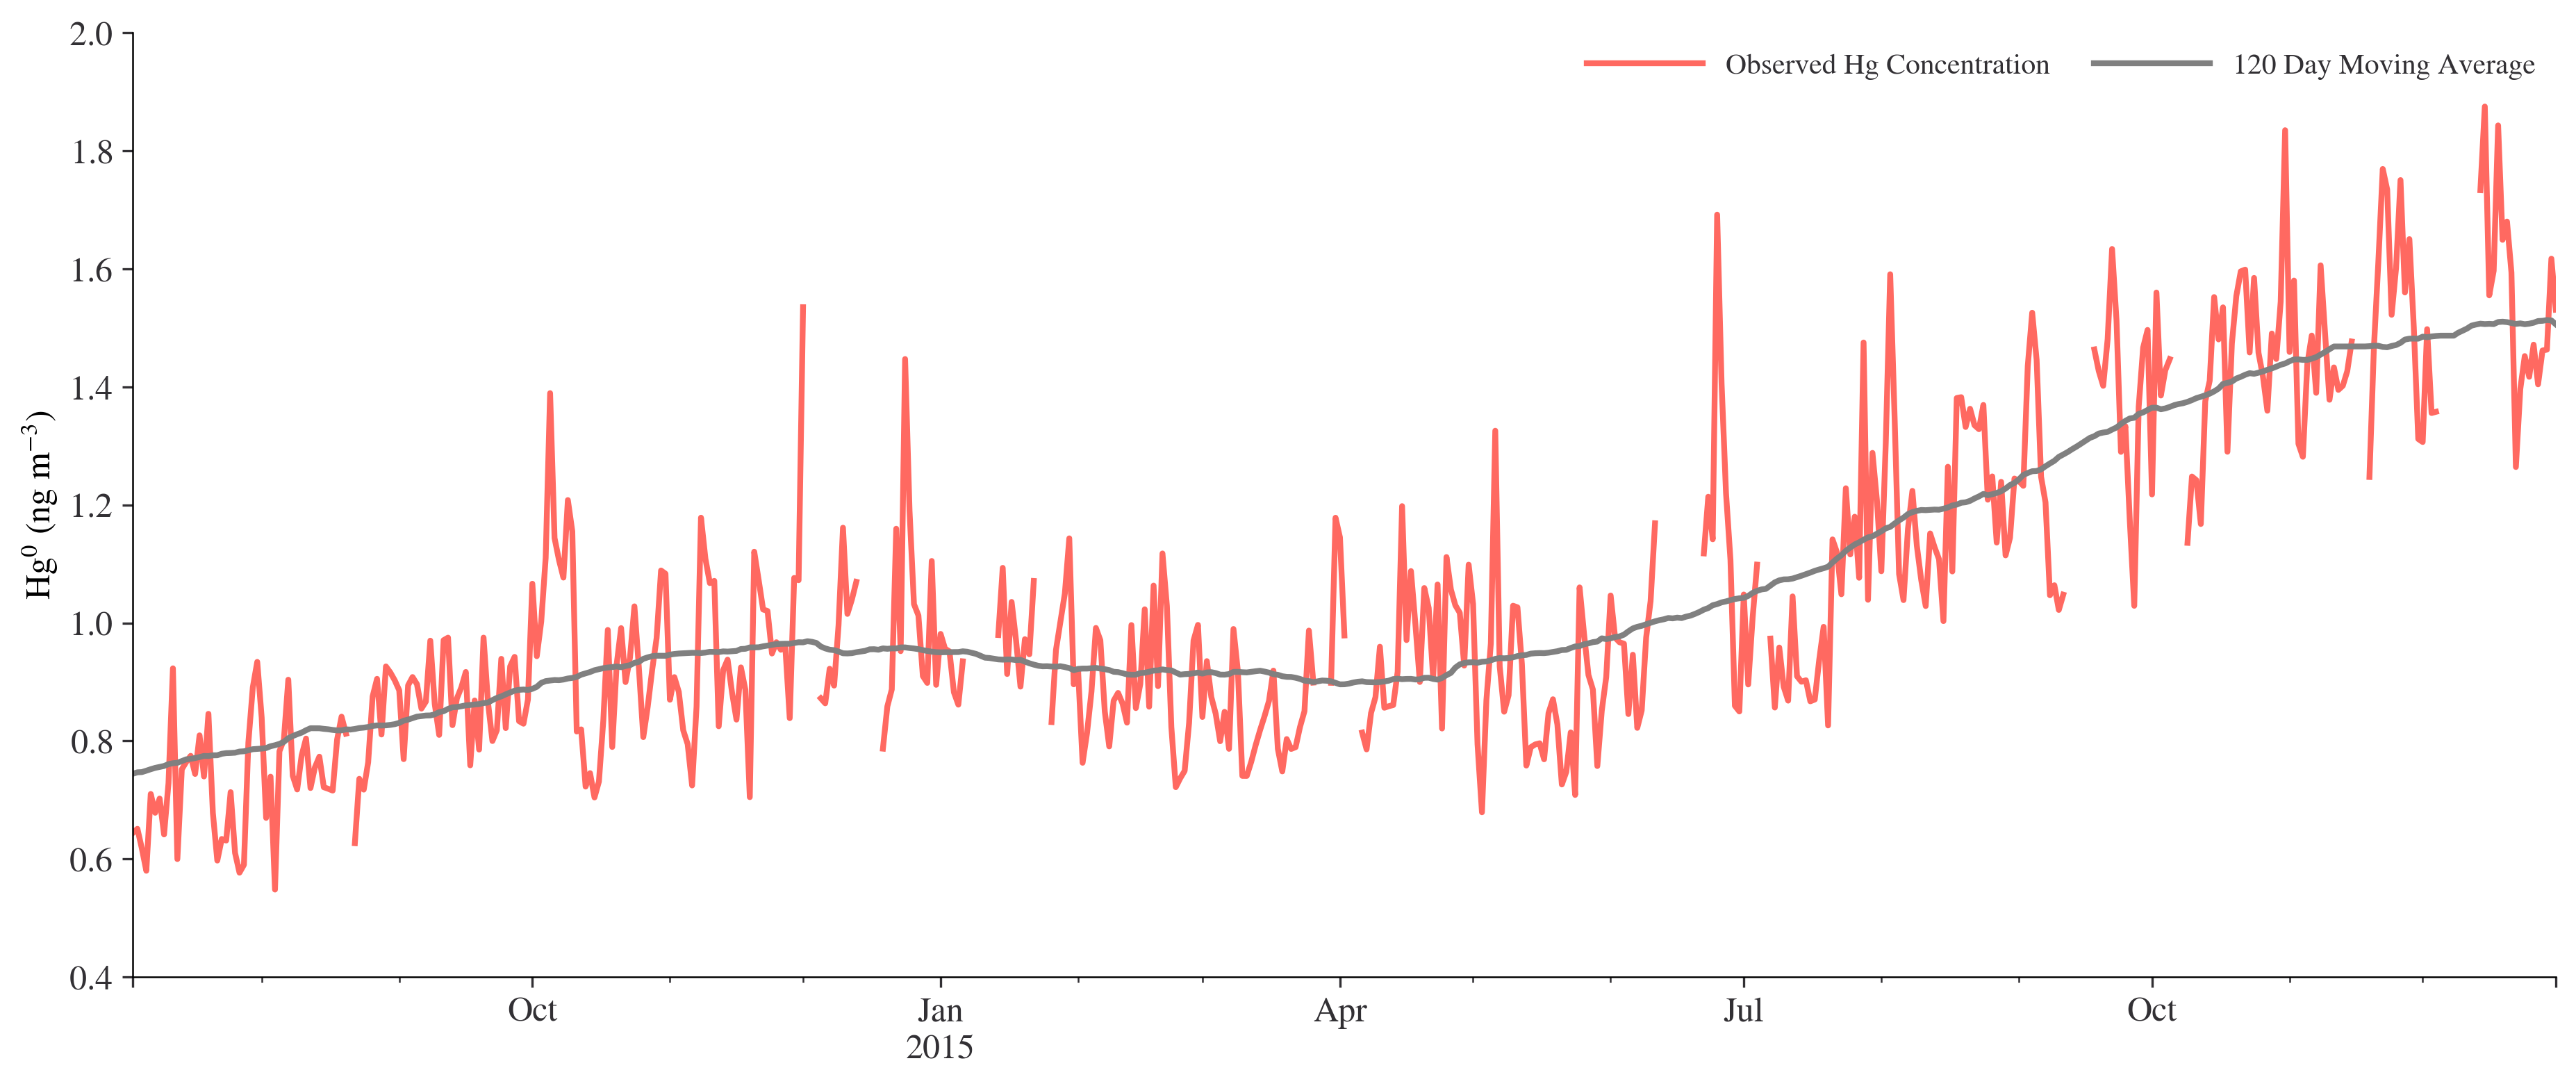

In [22]:
fig, ax = plt.subplots(figsize=(15,6))
plt.style.use('/home/tzd/fs03/d1/tzd/Data_analysis/MIT_TPP_thesis/JPnotebooks/plot_style.txt')
obs.value.plot(color = plot_colors['Observations'],label = 'Observed Hg Concentration',ax=ax)
obs_av.value.plot(color = 'grey',label = '120 Day Moving Average',ax=ax)
#plt.title("Hg Concentration at CHC", fontsize=16)
plt.ylabel('Hg$^0$ (ng m$^{-3}$)')
plt.xlabel('')
plt.xticks(rotation=0)
plt.legend(frameon=False,loc='best',ncol=2,handlelength=4)#labels=["Observed Hg Concentration","120 day Moving Average"],loc = 2, bbox_to_anchor = (1,1)
name='ObsTimeSeries.pdf'
savepath='/home/tzd/fs03/d1/tzd/Data_analysis/MIT_TPP_thesis/figures/GMOS_Sites/'+name
fig.savefig(savepath,bbox_inches='tight')
plt.show()

# Compare Observations with Model

## Compare Observations with Base Model

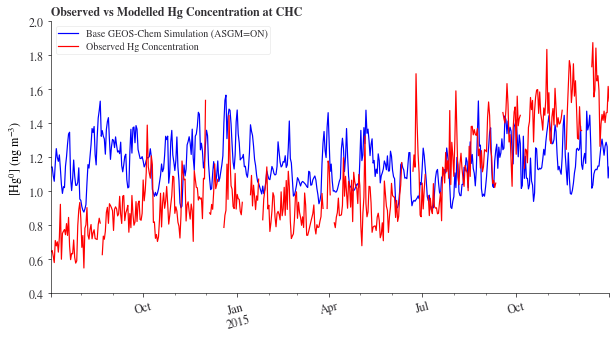

In [21]:
fig, ax = plt.subplots(figsize=(10,5))
Hg0.SpeciesConc_Hg0[obs_start_d:].plot(color = 'blue',label = 'Base GEOS-Chem Simulation (ASGM=ON)',ax=ax)
obs.value.plot(color = 'red',label = 'Observed Hg Concentration',ax=ax)
#obs_av.value.plot(color = 'grey',label = '120 Day Moving Average',ax=ax)

plt.title("Observed vs Modelled Hg Concentration at CHC", fontsize=12,fontweight="bold")
plt.ylabel('[Hg$^0$] (ng m$^{-3}$)')
plt.xlabel('')
plt.xticks(rotation=15)
plt.legend()#labels=["Observed Hg Concentration","120 day Moving Average"],loc = 2, bbox_to_anchor = (1,1)
plt.show()

## Compare Observations with Base Model and ASGM Signal 

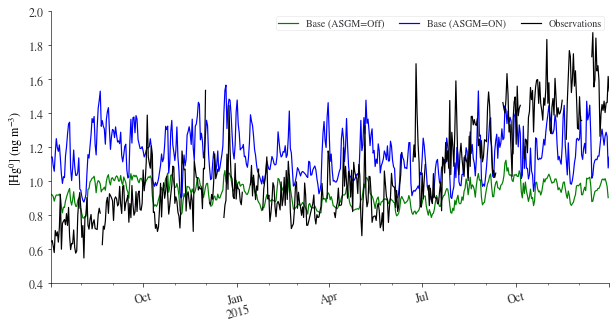

In [22]:
fig, ax = plt.subplots(figsize=(10,5))
Hgo_no_asgm.SpeciesConc_Hg0[obs_start_d:].plot(color = 'green',label = 'Base (ASGM=Off)',ax=ax)
Hg0.SpeciesConc_Hg0[obs_start_d:].plot(color = 'blue',label = 'Base (ASGM=ON)',ax=ax)
obs.value.plot(color = 'k',label = 'Observations',ax=ax)
#ASGM_signal[obs_start_d:].plot(color = 'coral',label = 'ASGM Signal ((ASGM=ON)-)',ax=ax)

#plt.title("Observed vs Modelled Hg Concentration at CHC", fontsize=12,fontweight="bold")
plt.ylabel('[Hg$^0$] (ng m$^{-3}$)')
plt.xlabel('')
plt.xticks(rotation=15)
plt.legend(ncol=3)#labels=["Observed Hg Concentration","120 day Moving Average"],loc = 2, bbox_to_anchor = (1,1)
plt.show()

## Compare Observations with Base Model no ASGM

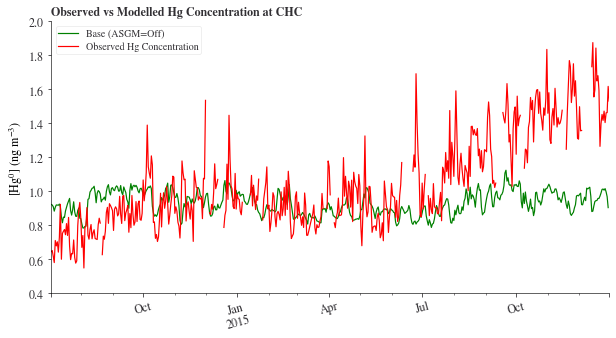

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
#Hg0.SpeciesConc_Hg0[obs_start_d:].plot(color = 'blue',label = 'Base GEOS-Chem Simulation (ASGM=ON)',ax=ax)
Hgo_no_asgm.SpeciesConc_Hg0[obs_start_d:].plot(color = 'green',label = 'Base (ASGM=Off)',ax=ax)
obs.value.plot(color = 'red',label = 'Observed Hg Concentration',ax=ax)


plt.title("Observed vs Modelled Hg Concentration at CHC", fontsize=12,fontweight="bold")
plt.ylabel('[Hg$^0$] (ng m$^{-3}$)')
plt.xlabel('')
plt.xticks(rotation=15)
plt.legend()#labels=["Observed Hg Concentration","120 day Moving Average"],loc = 2, bbox_to_anchor = (1,1)
plt.show()

## Compare Observations with Base Model Hi Resolution

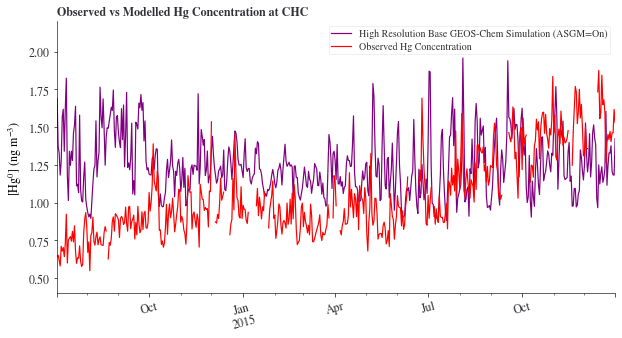

In [24]:
fig, ax = plt.subplots(figsize=(10,5))
#Hg0.SpeciesConc_Hg0[obs_start_d:].plot(color = 'blue',label = 'Base GEOS-Chem Simulation (ASGM=ON)',ax=ax)
Hg0_Hres.SpeciesConc_Hg0[obs_start_d:].plot(color = 'purple',label = 'High Resolution Base GEOS-Chem Simulation (ASGM=On)',ax=ax)
obs.value.plot(color = 'red',label = 'Observed Hg Concentration',ax=ax)


plt.title("Observed vs Modelled Hg Concentration at CHC", fontsize=12,fontweight="bold")
plt.ylabel('[Hg$^0$] (ng m$^{-3}$)')
plt.xlabel('')
plt.xticks(rotation=15)
plt.legend()#labels=["Observed Hg Concentration","120 day Moving Average"],loc = 2, bbox_to_anchor = (1,1)
plt.show()

In [25]:
obs.index =  obs.index.normalize()
obs

,value
tstamp,
2014-07-03 00:00:00+00:00,0.644308
2014-07-04 00:00:00+00:00,0.651114
2014-07-05 00:00:00+00:00,0.617688
2014-07-06 00:00:00+00:00,0.579989
...,...
2015-12-28 00:00:00+00:00,1.461608
2015-12-29 00:00:00+00:00,1.463048
2015-12-30 00:00:00+00:00,1.617204
2015-12-31 00:00:00+00:00,1.530699


# Calculate Metrics

In [26]:
df_combined=Hg0_Hres.SpeciesConc_Hg0[obs_start_d:].to_frame(name='GC_HiRes_ASGM')
df_combined['GC_LoRes_ASGM']=Hg0.SpeciesConc_Hg0[obs_start_d:]
df_combined['GC_LoRes_NoASGM']=Hgo_no_asgm.SpeciesConc_Hg0[obs_start_d:]
df_combined['Observations']=obs.value

In [27]:
df_combined=df_combined[:'2015-12-30']
df_combined_noHR=df_combined[['GC_LoRes_ASGM','GC_LoRes_NoASGM','Observations']]
df_combined_noHR

,GC_LoRes_ASGM,GC_LoRes_NoASGM,Observations
time,,,
2014-07-03,1.141870,0.921938,NaN
2014-07-04,1.142869,0.919110,NaN
2014-07-05,1.091087,0.909431,NaN
2014-07-06,1.058690,0.882850,NaN
...,...,...,...
2015-12-27,1.265974,1.015476,NaN
2015-12-28,1.288415,0.995842,NaN
2015-12-29,1.262660,0.967954,NaN
2015-12-30,1.077962,0.903569,NaN


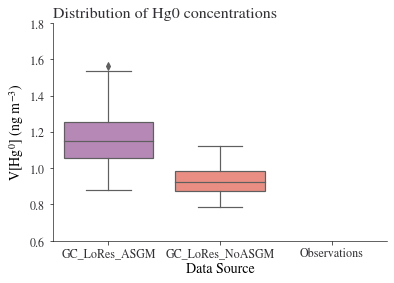

In [28]:
import seaborn as sns
# bplot = sns.boxplot(data=df_combined_noHR)
#boxes = ax.artists
colors={'GC_LoRes_NoASGM':'g','GC_LoRes_ASGM':'b','Observations':'r'}

clist=list(colors.keys())
df = pd.DataFrame(data=df_combined_noHR, columns=["GC_LoRes_ASGM", "GC_LoRes_NoASGM", "Observations"])
boxplot = sns.boxplot(x="variable", y="value", data=pd.melt(df))
boxplot.axes.set_title("Distribution of Hg0 concentrations", fontsize=16)
boxplot.set_xlabel("Data Source", fontsize=14)
boxplot.set_ylabel("V[Hg$^0$] (ng m$^{-3}$)", fontsize=14)
plt.show()

## Mean Square Error

In [29]:
from scipy.stats import iqr
from scipy import mean
import statistics as stat
def nrmse(obs,pred,type='sd'):
    squared_sums = sum((obs - pred)**2)
    mse = squared_sums/len(obs)
    rmse= np.sqrt(mse)
    if type == "sd":
        nrmse = rmse/np.std(obs)
    elif type == "mean":
        nrmse = rmse/np.mean(obs)
    elif type == "maxmin":
        nrmse = rmse/ (max(obs) - min(obs))
    elif type == "iq":
        nrmse = rmse/ (np.quantile(obs, 0.75) - np.quantile(obs, 0.25))
    else:
         print("Wrong type!")
    nrmse = round(nrmse, 3)
    return(nrmse)

In [30]:
emetrics=['sd',"mean","maxmin","iq"]
sims=['GC_LoRes_NoASGM','GC_LoRes_ASGM','GC_HiRes_ASGM']
simNRMSE={}
for sim in sims:
    nnrmse={}
    for metric in emetrics:
        nnrmse[metric]=nrmse(df_combined['Observations'],df_combined[sim],metric)
    
    simNRMSE[sim]=nnrmse  
pd.DataFrame(simNRMSE)

,GC_LoRes_NoASGM,GC_LoRes_ASGM,GC_HiRes_ASGM
sd,NaN,NaN,NaN
mean,NaN,NaN,NaN
maxmin,NaN,NaN,NaN
iq,NaN,NaN,NaN


In [31]:
def estpower(yobs,ypred):
    res=(ypred/yobs-1)*100
    return res

nan


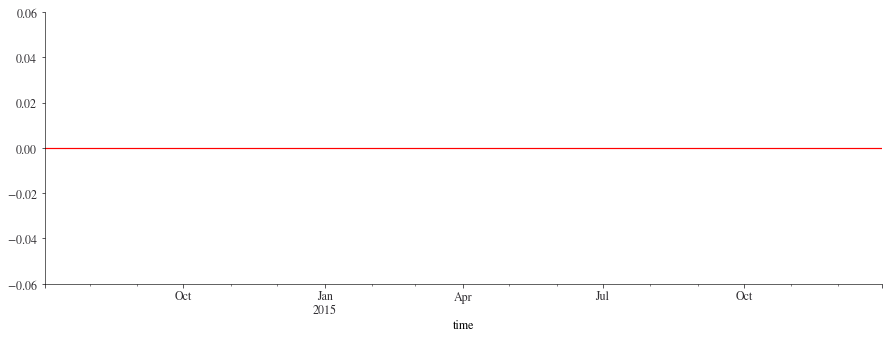

nan


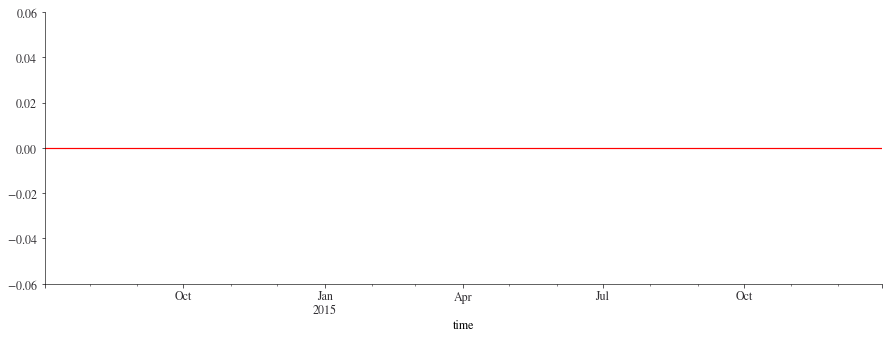

nan


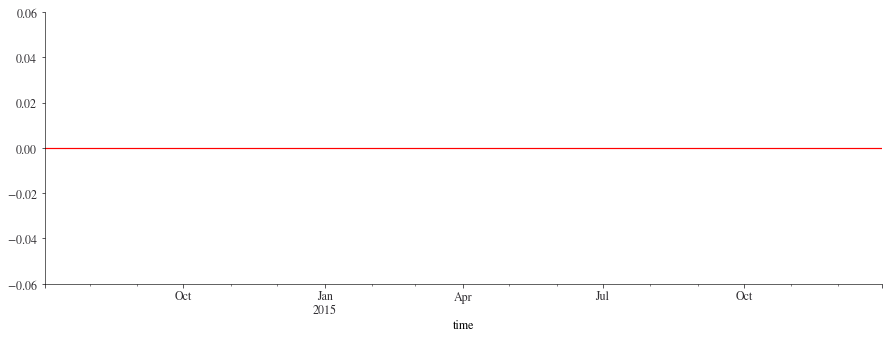

In [32]:
for sim in sims:
    fig, ax = plt.subplots(figsize=(15,5))
    est=estpower(df_combined['Observations'],df_combined[sim])
    print(np.mean(est))
    est.plot(ax=ax)
    plt.axhline(y = 0, color = 'r', linestyle = '-')
    plt.show()

In [33]:
# Scatter Plot
def myscater(x,y,xname,yname,tit):

    lineStart =x.min() 
    lineEnd = x.max()  

    plt.figure()
    plt.scatter(x, y, color = 'k', alpha=0.5)
    plt.plot([lineStart, lineEnd], [lineStart, lineEnd], color = 'r')
    plt.xlim(lineStart, lineEnd)
    plt.ylim(lineStart, lineEnd)
    plt.xlabel(xname)
    plt.ylabel(yname)
    plt.title(tit)
    plt.show()

## Chi-squared to measure goodness of fit

In [34]:
# a helper function to calculate the Chi-Square value
def Chi_Square(obs_freq, exp_freq):
    count = len(obs_freq)
    chi_sq = 0
    for i in range(count):
        x = (obs_freq[i] - exp_freq[i]) ** 2
        x = x / exp_freq[i]
        chi_sq += x
    return chi_sq
# critical Chi-Square - percent point function
p = 0
DOF = len(dice['observed']) - p - 1
stats.chi2.ppf(0.95, DOF)

NameError: name 'dice' is not defined


GC_HiRes_ASGM

Pearsons correlation:0.0692 and the R-squared value is: 0.004793

The spearman orrelation between GC_HiRes_ASGM and observations is: 0.0869  and the Ttest is :-15.14 the p-value is :3.6681945062379795e-47



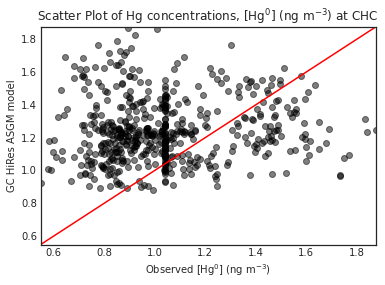


GC_LoRes_ASGM

Pearsons correlation:0.1113 and the R-squared value is: 0.012385

The spearman orrelation between GC_LoRes_ASGM and observations is: 0.1166  and the Ttest is :-9.98 the p-value is :1.7341266144066285e-22



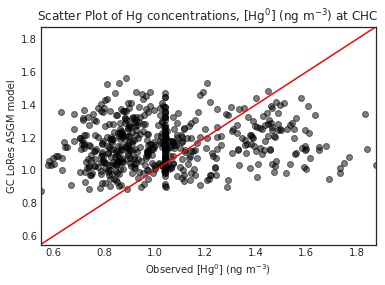


GC_LoRes_NoASGM

Pearsons correlation:0.2575 and the R-squared value is: 0.066316

The spearman orrelation between GC_LoRes_NoASGM and observations is: 0.25  and the Ttest is :9.63 the p-value is :3.903172699743662e-21



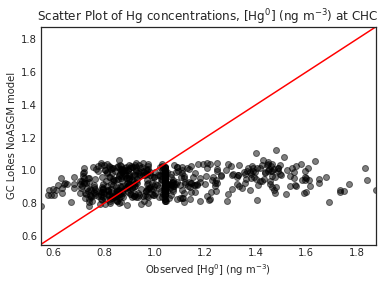

In [ ]:
from scipy import stats
from sklearn.metrics import r2_score 
models=['GC_HiRes_ASGM','GC_LoRes_ASGM','GC_LoRes_NoASGM']
obs_d='Observations'
for mod in models:
    print('\n'+mod+'\n')
    tit= 'Scatter Plot of Hg concentrations, [Hg$^0$] (ng m$^{-3}$) at CHC'
    xname='Observed [Hg$^0$] (ng m$^{-3}$)'
    yname=mod.replace('_',' ')+' model'
    
    # calculate Pearson's correlation
    corr_p, _ = stats.pearsonr(df_0NA[obs_d],df_0NA[mod])
    print(f'Pearsons correlation:{round(corr_p,4)} and the R-squared value is: {round(corr_p**2,6)}\n')
    # Perform the two sample t-test with equal variances
    t_test=stats.ttest_ind(a=df_0NA[obs_d], b=df_0NA[mod], equal_var=True)
    
    #r= Chi_Square(df_0NA[obs_d],df_0NA[mod])
    #print(f"Chi-sqare for {mod} is :{r}  \n")
    #print(stats.chisquare(df_0NA[obs_d],df_0NA[mod]))
    #R_square = r2_score(df_0NA[obs_d],df_0NA[mod])
    corr_s=stats.spearmanr(df_0NA[obs_d], df_0NA[mod])
    print(f"The spearman orrelation between {mod} and observations is: {round(corr_s[0],4)}  and the Ttest is :{round(t_test[0],2)} the p-value is :{t_test[1]}\n")#The R-squared Value of {mod} is: {R_square} \
    myscater(df_0NA[obs_d],df_0NA[mod],xname,yname,tit)

𝑅2 compares the fit of the chosen model with that of a horizontal straight line (the null hypothesis). If the chosen model fits worse than a horizontal line, then 𝑅2 is negative. Note that 𝑅2 is not always the square of anything, so it can have a negative value without violating any rules of math. 𝑅2 is negative only when the chosen model does not follow the trend of the data, so fits worse than a horizontal line.

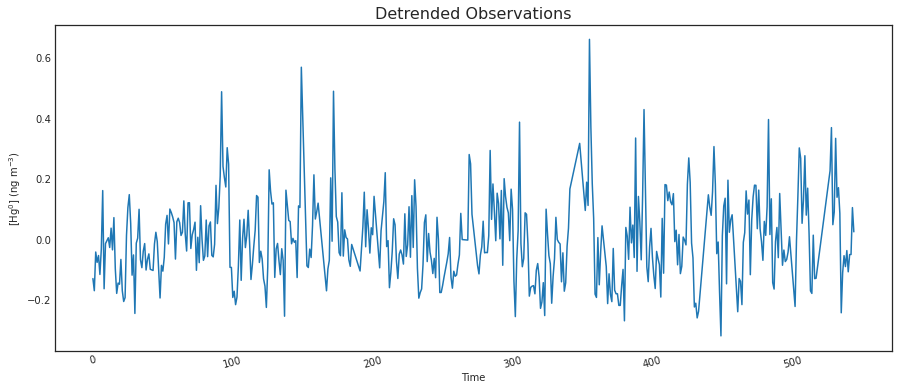

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
sns.lineplot(data=df_all['Obs_detrend'],ax=ax)
#sns.lineplot(data=obs_av,ax=ax)
plt.title("Detrended Observations", fontsize=16)
plt.ylabel('[Hg$^0$] (ng m$^{-3}$)')
plt.xlabel('Time')
plt.xticks(rotation=15)
#plt.legend(labels=["Raw Observations","120 day Moving Average"],loc = 2, bbox_to_anchor = (1,1))
plt.show()

# Scale Factors for Modifying Emissions 

In [ ]:
scalors ={'spun':[7.748216414,15.496432828],'npun':[11.66649464,23.33298928],'mdd':[1.38677,2.77354],'aqp':[13.6339,27.2678], 'apr':[18.9904,9.4952]}

In [ ]:
#function for calculating signal 
def sig_calc(region,mass):
    Hg0,_,Hg0_modified = unit_chng(region)
    region_sig =region+'_signal'
    signal = Hg0_modified.SpeciesConc_Hg0-Hg0.SpeciesConc_Hg0
    Hg_sig= ((signal)/(scalors[region][1]-scalors[region][0]))*(mass-scalors[region][0])
    return Hg_sig

# Signal Modification

In [ ]:
def mdfy_signal(region):
  Hg0,_,_ = unit_chng(region)
  df_mods_Hg0=pd.DataFrame()
  # signal = Hg0_modified.SpeciesConc_Hg0-Hg0.SpeciesConc_Hg0
  # scala = scalors[region]
  x=[50,40,30,20,10,5,2.5,0] # amount of emissions added t
  for i in x:
        # if region == 'apr':
        #   y_x=(i/(-0.5*scala))+2
        # else:
        #   y_x=(i/scala)-1
        modified = sig_calc(region,i)+ Hg0.SpeciesConc_Hg0
        if i==40:
          df_mods_Hg0['Hg0_modified_40']= modified.resample('D').mean()
        elif i==30:
          df_mods_Hg0['Hg0_modified_30']= modified.resample('D').mean()
        elif i==20:
          df_mods_Hg0['Hg0_modified_20']= modified.resample('D').mean()
        elif i==10:
          df_mods_Hg0['Hg0_modified_10']= modified.resample('D').mean()
        elif i==2.5:
          df_mods_Hg0['Hg0_modified_2p5']= modified.resample('D').mean()
        elif i==5:
          df_mods_Hg0['Hg0_modified_5']= modified.resample('D').mean()
        elif i==0:
          df_mods_Hg0['Hg0_modified_0']= modified.resample('D').mean()
        elif i==50:
          df_mods_Hg0['Hg0_modified_50']= modified.resample('D').mean()
  return df_mods_Hg0

In [ ]:
# set style - When adding multple boxplots I like use whitegird 
Hg0_modified =mdfy_signal('npun')
sns.set(style='whitegrid')
#Hg0_modified.drop(columns=['lev','lat','lon'],inplace=True)
fig, ax = plt.subplots(figsize=(8,6))

sns.boxplot(data=Hg0_modified,showmeans=True,

            meanprops={"marker":"o",

                       "markerfacecolor":"white",

                       "markeredgecolor":"black",

                      "markersize":"10"}, width=0.7,whis=[10, 90])#notch=True, ) # df[['p1_satisfaction','p2_satisfaction','p3_satisfaction']]
#sns.swarmplot(data=df_all, color=".25")
plt.ylabel('[Hg$^0$] (ng m$^{-3}$)')
x = ['Hg0_modified_50','Hg0_modified_40','Hg0_modified_30','Hg0_modified_20','Hg0_modified_10','Hg0_modified_7.75','Hg0_modified_5','Hg0_modified_0']
ax.set_xticklabels(x,rotation=45)
# Titles and labels
plt.title("Comparison of Standardized Model Runs with Standardized Observations", fontsize=16)
plt.show()

# Prep Plots 

In [ ]:
Obs = get_chc().reset_index()
Obs['tstamp']=pd.to_datetime(Obs.tstamp,utc=True,  format='%Y%m%d', errors='ignore').dt.date
Hg0,_,Hg0_modified1 = unit_chng('mdd')
#modify time for modified model output 
Hg0_modified1= Hg0_modified1.reset_index()
Hg0_modified1['time']=pd.to_datetime(Hg0_modified1.time,utc=True,  format='%Y%m%d', errors='ignore').dt.date
Hg0_modified1=Hg0_modified1[Hg0_modified1['time'].isin(Obs.tstamp)]
#modify date and time for base model output
Hg0= Hg0.reset_index()
Hg0['time']=pd.to_datetime(Hg0.time,utc=True,  format='%Y%m%d', errors='ignore').dt.date
Hg0=Hg0[Hg0['time'].isin(Obs.tstamp)]


In [ ]:
Hg0_modified= mdfy_signal('mdd').Hg0_modified_20
Hg0_modified

In [ ]:
no_asgm = pd.DataFrame(get_model_ts('CHC')).reset_index()
no_asgm['time'] = pd.to_datetime(no_asgm.time,utc=True,  format='%Y%m%d', errors='ignore').dt.date
no_asgm

In [ ]:
Hg0,_,_ = unit_chng('mdd')

In [ ]:
def prep_df(region):
    site= 'CHC'
    Hg0,Hg0_Hres,_ = unit_chng(region)
    Obs = get_chc().reset_index()
    Hg0_modified1= mdfy_signal(region).Hg0_modified_30
    no_asgm = pd.DataFrame(get_model_ts(site)).reset_index()
    Obs_detrended = get_detrended()
    #Make sure start dates are aligned with observation timeline 

    Obs['tstamp']=pd.to_datetime(Obs.tstamp,utc=True,  format='%Y%m%d', errors='ignore').dt.date
    Obs = Obs[Obs['tstamp'].isin(Obs_detrended.tstamp)].set_index('tstamp')
    #Hg0,Hg0_modified1 = unit_chng('mdd')
    #modify time for modified model output 
    Hg0_modified1= Hg0_modified1.reset_index()
    Hg0_modified1['time']=pd.to_datetime(Hg0_modified1.time,utc=True,  format='%Y%m%d', errors='ignore').dt.date
    Hg0_modified1=Hg0_modified1[Hg0_modified1['time'].isin(Obs_detrended.tstamp)].set_index('time')
    #modify date and time for base model output
    Hg0= Hg0.reset_index() #.drop(['height', 'lat','lon'], axis = 1)
    Hg0['time']=pd.to_datetime(Hg0.time,utc=True,  format='%Y%m%d', errors='ignore').dt.date
    Hg0=Hg0[Hg0['time'].isin(Obs_detrended.tstamp)].set_index('time')
    #modify date and time for base no ASGM output
    no_asgm['time'] = pd.to_datetime(no_asgm.time,utc=True,  format='%Y%m%d', errors='ignore').dt.date
    no_asgm = no_asgm[no_asgm['time'].isin(Obs_detrended.tstamp)].set_index('time')

    #modify date and time for base High Res output
    Hg0_Hres= Hg0_Hres.reset_index() #.drop(['height', 'lat','lon'], axis = 1)
    Hg0_Hres['time']=pd.to_datetime(Hg0_Hres.time,utc=True,  format='%Y%m%d', errors='ignore').dt.date
    Hg0_Hres=Hg0_Hres[Hg0_Hres['time'].isin(Obs_detrended.tstamp)].set_index('time')

    #Concatenate DataFrames 
    Obs_detrended = Obs_detrended.set_index('tstamp')
    df = pd.concat([no_asgm,Hg0,Hg0_Hres,Hg0_modified1,Obs,Obs_detrended], axis=1)
    df.columns = ['GC_No_ASGM','GC_Base_ASGM','GC_Base_Hres_ASGM','GC_Modified_ASGM','Observations','Observations_detrended']
    return df

## Sanity Check

In [ ]:
 prep_df('mdd')

# Analysis

In [ ]:
#standardize
def stprep_df(region):
    site= 'CHC'
    Hg0,Hg0_Hres,_= unit_chng(region)
    Obs = get_chc().reset_index()
    Hg0_modified1= mdfy_signal(region).Hg0_modified_20
    no_asgm = pd.DataFrame(get_model_ts(site)).reset_index()
    Obs_detrended = get_detrended()
    #Make sure start dates are aligned with observation timeline 

    Obs['tstamp']=pd.to_datetime(Obs.tstamp,utc=True,  format='%Y%m%d', errors='ignore').dt.date
    Obs = Obs[Obs['tstamp'].isin(Obs_detrended.tstamp)].set_index('tstamp')
    #modify time for modified model output 
    # Hg0_modified1= Hg0_modified1.reset_index()
    # Hg0_modified1['time']=pd.to_datetime(Hg0_modified1.time,utc=True,  format='%Y%m%d', errors='ignore').dt.date
    # Hg0_modified1=Hg0_modified1[Hg0_modified1['time'].isin(Obs_detrended.tstamp)].set_index('time')
    #modify date and time for base model output
    Hg0= Hg0.reset_index() #.drop(['height', 'lat','lon'], axis = 1)
    Hg0['time']=pd.to_datetime(Hg0.time,utc=True,  format='%Y%m%d', errors='ignore').dt.date
    Hg0=Hg0[Hg0['time'].isin(Obs_detrended.tstamp)].set_index('time')
    #modify date and time for base High Res output
    Hg0_Hres= Hg0_Hres.reset_index() #.drop(['height', 'lat','lon'], axis = 1)
    Hg0_Hres['time']=pd.to_datetime(Hg0_Hres.time,utc=True,  format='%Y%m%d', errors='ignore').dt.date
    Hg0_Hres=Hg0_Hres[Hg0_Hres['time'].isin(Obs_detrended.tstamp)].set_index('time')
    #modify date and time for base High Res output
    no_asgm['time'] = pd.to_datetime(no_asgm.time,utc=True,  format='%Y%m%d', errors='ignore').dt.date
    no_asgm = no_asgm[no_asgm['time'].isin(Obs_detrended.tstamp)].set_index('time')
    Obs_detrended = Obs_detrended.set_index('tstamp')
    #Concatenate DataFrames  in to one dataframe
    #df = pd.concat([no_asgm,Hg0,Hg0_Hres,Hg0_modified1,Obs,Obs_detrended], axis=1)
    df = pd.concat([no_asgm,Hg0,Hg0_Hres,Obs,Obs_detrended], axis=1)
    #df.columns = ['GC_No_ASGM','GC_Base_ASGM','GC_Base_Hres_ASGM','GC_Modified_ASGM','Observations','Observations_detrended']
    df.columns = ['GC_No_ASGM','GC_Base_ASGM','GC_Base_Hres_ASGM','Observations','Observations_detrended']
    df['GC_No_ASGM'] = df['GC_No_ASGM']-df['GC_No_ASGM'].mean()
    df['GC_Base_Hres_ASGM'] = df['GC_Base_Hres_ASGM']-df['GC_Base_Hres_ASGM'].mean()
    df['GC_Base_ASGM'] = df['GC_Base_ASGM']-df['GC_Base_ASGM'].mean()
    #df['GC_Modified_ASGM'] = df['GC_Modified_ASGM']-df['GC_Modified_ASGM'].mean()
    df['Observations'] = df['Observations']-df['Observations'].mean()
    
    return df

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

sns.boxplot(data=prep_df('spun'),showmeans=True,

            meanprops={"marker":"o",

                       "markerfacecolor":"white",

                       "markeredgecolor":"black",

                      "markersize":"10"}, width=0.7,whis=[10, 90])#notch=True, ) # df[['p1_satisfaction','p2_satisfaction','p3_satisfaction']]
#sns.swarmplot(data=df_all, color=".25")
plt.ylabel('[Hg$^0$] (ng m$^{-3}$)')
# Titles and labels
plt.title("Comparison of Model Runs with Observations", fontsize=16)
plt.xticks(rotation=15)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

sns.boxplot(data=stprep_df('spun'),showmeans=True,

            meanprops={"marker":"o",

                       "markerfacecolor":"white",

                       "markeredgecolor":"black",

                      "markersize":"10"}, width=0.7,whis=[10, 90])#notch=True, ) # df[['p1_satisfaction','p2_satisfaction','p3_satisfaction']]
#sns.swarmplot(data=df_all, color=".25")
plt.ylabel('[Hg$^0$] (ng m$^{-3}$)')
# Titles and labels
plt.title("Comparison of Model Runs with Observations", fontsize=16)
plt.xticks(rotation=15)
plt.show()

# Further Analysis 

### Find the IQR of the detrended observations 

In [ ]:
prep_df('spun')['Observations_detrended']

In [ ]:
LQ=prep_df('spun')['Observations_detrended'].quantile([0.25]).values[0]
UQ=prep_df('spun')['Observations_detrended'].quantile([0.75]).values[0]
OBS_IQR=UQ-LQ

### Find IQRs for different emission amounts in Specified region

In [ ]:
def IQRs(region):
  Hg0_modified =mdfy_signal(region)
  GC_mod_IQR = (Hg0_modified.describe().iloc[6]-Hg0_modified.describe().iloc[4]).to_frame()
  GC_mod_IQR.rename(columns = {0:'IQRs'}, inplace = True)
  return GC_mod_IQR.IQRs.iloc[::-1]

In [ ]:
def means(region):
  Hg0_modified =mdfy_signal(region)
  GC_mod_mean = Hg0_modified.describe().iloc[1].to_frame()
  GC_mod_mean.rename(columns = {'mean':'means'}, inplace = True)
  return GC_mod_mean.means.iloc[::-1]

## sanity check

In [ ]:
means('mdd')

### Plot South Puno IQRs and Compare with detrended observation IQR

In [ ]:
#function to find the IQR of a specific column of a dataframe
def df_IQR(df,column_ind):
  LQ=df.quantile([0.25]).values[0][column_ind]
  UQ=df.quantile([0.75]).values[0][column_ind]
  return UQ-LQ

In [ ]:
gBoxes['mdd']

In [ ]:
for region in gBoxes.keys():

    fig, ax = plt.subplots(figsize=(8,6))
    x = [0,5,7.75,10,20,30,40,50]
    df_all = stprep_df(region)
    LQ=stprep_df(region)['Observations_detrended'].quantile([0.25]).values[0]
    UQ=stprep_df(region)['Observations_detrended'].quantile([0.75]).values[0]
    OBS_IQR=UQ-LQ
    #find IQR for base 
    Base_NoASGM_IQR = df_IQR(df_all,0)
    Base_WASGM_IQR = df_IQR(df_all,1)
    Base_Hres_IQR = df_IQR(df_all,2)

    name=gBoxes[region]
    iqrs=IQRs(region)
    #Spun_IQRs.iloc[::-1].values.plot()
    plt.plot(x[:], iqrs[:],'o',label=(name+' Adjusted \n Emissions IQR'))
    plt.ylabel('IQR')
    plt.xlabel(('Total Emissions from '+name))
    plt.axhline(y=OBS_IQR, color="red", linestyle="--",label='Detrended_OBS_IQR')
    plt.axhline(y=Base_NoASGM_IQR, color="blue", linestyle="--",label='Base_NoASGM_IQR')
    plt.axhline(y=Base_WASGM_IQR, color="green", linestyle="--",label='Base_WASGM_IQR')
    plt.axhline(y=Base_Hres_IQR, color="black", linestyle="--",label='Base_HresWASGM_IQR')
    plt.xticks(rotation=45)
    plt.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
    plt.grid(False)
    #plt.legend()
    plt.show()
    #ax.set_xticklabels(x,rotation=45)



In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

sns.boxplot(data=prep_df(region),showmeans=True,

            meanprops={"marker":"o",

                       "markerfacecolor":"white",

                       "markeredgecolor":"black",

                      "markersize":"10"}, width=0.7,whis=[10, 90])#notch=True, ) # df[['p1_satisfaction','p2_satisfaction','p3_satisfaction']]
#sns.swarmplot(data=df_all, color=".25")
plt.ylabel('[Hg$^0$] (ng m$^{-3}$)')
# Titles and labels
plt.title("Comparison of Model Runs with Observations", fontsize=16)
plt.xticks(rotation=15)
plt.show()

In [ ]:
region = 'mdd'
Hg0_modified =mdfy_signal(region)
Hg0_modified.describe()


In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
x = [0,5,7.75,10,20,30,40,50]
region = 'mdd'
df_all = prep_df(region)
LQ=prep_df(region)['Observations_detrended'].quantile([0.25]).values[0]
UQ=prep_df(region)['Observations_detrended'].quantile([0.75]).values[0]
OBS_IQR=UQ-LQ
#find IQR for base 
Base_NoASGM_IQR = df_IQR(df_all,0)
Base_WASGM_IQR = df_IQR(df_all,1)
means('mdd')
iqrs=IQRs(region)
#Spun_IQRs.iloc[::-1].values.plot()
plt.plot(x[:], iqrs,'o',label='Madre de Dios  Adjusted \n Emissions IQR')
plt.ylabel('IQR')
plt.xlabel('Total Emissions from Madre de Dios')
plt.axhline(y=OBS_IQR, color="red", linestyle="--",label='OBS_IQR')
plt.axhline(y=Base_NoASGM_IQR, color="blue", linestyle="--",label='Base_NoASGM_IQR')
plt.axhline(y=Base_WASGM_IQR, color="green", linestyle="--",label='Base_WASGM_IQR')
plt.xticks(rotation=45)
plt.grid(False)
plt.legend()
plt.show()
#ax.set_xticklabels(x,rotation=45)

fig, ax = plt.subplots(figsize=(8,6))

sns.boxplot(data=prep_df(region),showmeans=True,

            meanprops={"marker":"o",

                       "markerfacecolor":"white",

                       "markeredgecolor":"black",

                      "markersize":"10"}, width=0.7,whis=[10, 90])#notch=True, ) # df[['p1_satisfaction','p2_satisfaction','p3_satisfaction']]
#sns.swarmplot(data=df_all, color=".25")
plt.ylabel('[Hg$^0$] (ng m$^{-3}$)')
# Titles and labels
plt.title("Comparison of Model Runs with Observations", fontsize=16)
plt.xticks(rotation=15)
plt.show()

## Plot Means and IQRS

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
region = 'mdd'
x = [0,2.5,5,10,20,30,40,50]
means('mdd')
iqrs=IQRs(region)
#Spun_IQRs.iloc[::-1].values.plot()
plt.plot(x[:], means('mdd'),'o-',label='Madre de Dios  Adjusted \n Emissions means')
plt.plot(x[:], means('spun'),'o-',label='South Puno  Adjusted \n Emissions means')
plt.plot(x[:], means('npun'),'o-',label='North Puno  Adjusted \n Emissions means')
plt.plot(x[:], means('aqp'),'o-',label='Arequipa  Adjusted \n Emissions means')
plt.plot(x[:], means('apr'),'o-',label='Apurimac  Adjusted \n Emissions means')
#plt.xticks(rotation=45)
plt.grid(False)
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
x = [0,2.5,5,10,20,30,40,50]
means('mdd')
iqrs=IQRs(region)
#Spun_IQRs.iloc[::-1].values.plot()
plt.plot(x[:], IQRs('mdd'),'o-',label='Madre de Dios  Adjusted \n Emissions IQRs')
plt.plot(x[:], IQRs('spun'),'o-',label='South Puno  Adjusted \n Emissions IQRs')
plt.plot(x[:], IQRs('npun'),'o-',label='North Puno  Adjusted \n Emissions IQRs')
plt.plot(x[:], IQRs('aqp'),'o-',label='Arequipa  Adjusted \n Emissions IQRs')
plt.plot(x[:], IQRs('apr'),'o-',label='Apurimac  Adjusted \n Emissions IQRs')
plt.xticks(rotation=45)
plt.grid(False)
plt.legend()
plt.show()

# Correlations 

In [ ]:
data=prep_df('spun')
df = data
df

In [ ]:
data=prep_df('apr')
df = data
df

## Calculations

In [ ]:
corr_regions={}
for key in gBoxes.keys():
    corr_region = {}
    data=prep_df(key)
    df = data
    corr_region['GC_No_ASGMvsObservations_detrended'], _=stats.spearmanr(df.GC_No_ASGM,df.Observations_detrended,nan_policy='omit')
    corr_region['GC_Base_ASGMvsObservations_detrended'], _=stats.spearmanr(df.GC_Base_ASGM,df.Observations_detrended,nan_policy='omit')
    corr_region['GC_Modified_ASGMvsObservations_detrended'], _=stats.spearmanr(df.GC_Modified_ASGM,df.Observations_detrended,nan_policy='omit')

    corr_regions[key]=corr_region

In [ ]:
data=prep_df('spun')
df = data
corr_region = {}
corr_region['GC_No_ASGMvsObservations_detrended'], _=stats.spearmanr(df.GC_No_ASGM,df.Observations_detrended,nan_policy='omit')
corr_region['GC_Base_ASGMvsObservations_detrended'], _=stats.spearmanr(df.GC_Base_ASGM,df.Observations_detrended,nan_policy='omit')
corr_region['GC_Modified_ASGMvsObservations_detrended'], _=stats.spearmanr(df.GC_Modified_ASGM,df.Observations_detrended,nan_policy='omit')
corr_region

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(df.GC_No_ASGM)
plt.plot(df.Observations_detrended)

In [ ]:
corelations=pd.DataFrame(corr_regions)

## Plot

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(corelations)
plt.xticks(rotation=45)
plt.legend(corelations.columns)
plt.show()

# find correlation between observations and Hi res output

In [ ]:
df

In [ ]:
stats.spearmanr(df.GC_Base_Hres_ASGM,df.Observations_detrended,nan_policy='omit')

In [ ]:
Hg0av120=df.GC_Base_ASGM.rolling(120, min_periods=1,center=True).mean()
Hg0LresDtrnd=df.GC_Base_ASGM-Hg0av120
Hg0LresDtrnd

In [ ]:
Hg0Hresav120=df.GC_Base_Hres_ASGM.rolling(120, min_periods=1,center=True).mean()
Hg0HresDtrnd=df.GC_Base_Hres_ASGM-Hg0Hresav120
Hg0HresDtrnd

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(df.Observations_detrended,Hg0LresDtrnd)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(df.Observations_detrended,Hg0HresDtrnd)

## Correlation Between High Resolution GEOSChem and Observations

In [ ]:
stats.spearmanr(Hg0HresDtrnd,df.Observations_detrended,nan_policy='omit')

## Correlation Between Low Resolution GEOSChem and Observations

In [ ]:
stats.spearmanr(Hg0LresDtrnd,df.Observations_detrended,nan_policy='omit')

In [ ]:
Hg0Lres_summary=pd.DataFrame(Hg0LresDtrnd).describe()

In [ ]:
Hg0Hres_summary=pd.DataFrame(Hg0HresDtrnd).describe()
Hg0Hres_summary

In [ ]:
fig, ax = plt.subplots(3,figsize=(15,6))
Hg0HresDtrnd.plot(color = 'green',label = 'High Res Model Output ',ax=ax[0])
ax[0].set_title(" Percentiles of Observations and Model Outputs", fontsize=16)
ax[0].axhline(y=0.112394, color='r', linestyle='-.')
ax[0].axhline(y=-0.126073, color='r', linestyle='--')
ax[0].text('2016-01-07',-0.126073,'25%')
ax[0].text('2016-01-07',0.112394,'75%')
ax[0].set_ylabel('[Hg$^0$] (ng m$^{-3}$)')

Hg0LresDtrnd.plot(color = 'blue',label = 'Low Res Model Output ',ax=ax[1])
ax[1].axhline(y=0.086520, color='r', linestyle='-.')
ax[1].axhline(y=-0.096756, color='r', linestyle='--')
ax[1].text('2016-01-07',-0.096756,'25%')
ax[1].text('2016-01-07',0.086520,'75%')
ax[1].set_ylabel('[Hg$^0$] (ng m$^{-3}$)')

df.Observations_detrended.plot(color = 'r',label = 'Low Res Model Output ',ax=ax[2])
ax[2].axhline(y=0.086520, color='k', linestyle='-.')
ax[2].axhline(y=-0.096756, color='k', linestyle='--')
ax[2].text('2016-01-07',-0.092871,'25%')
ax[2].text('2016-01-07',0.083017,'75%')
ax[2].set_ylabel('[Hg$^0$] (ng m$^{-3}$)')
plt.xlabel('Time')

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
Hg0HresDtrnd.plot(color = 'green',label = 'High Res Model Output ',ax=ax)
Hg0LresDtrnd.plot(color = 'blue',label = 'Low Res Model Output',ax=ax)
df.Observations_detrended.plot(color = 'red',label = 'Observations',ax=ax)

plt.title(" Detrended Observations vs High and Low Resolution Model Output", fontsize=16)
plt.ylabel('[Hg$^0$] (ng m$^{-3}$)')
plt.xlabel('Time')
plt.xticks(rotation=15)
plt.legend(labels=["High Resolution(0.25x0.31) Model Output",'Low Res(2x2.5) Model Output',"Detrended Observations"],loc = 'upper center', bbox_to_anchor=(0.5, 1.02),
          fancybox=True,shadow=True, ncol=3)
plt.grid(False)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
df.GC_Base_Hres_ASGM.plot(color = 'green',label = 'High Res Model Outpul ',ax=ax)
df.Observations.plot(color = 'red',label = 'Observations',ax=ax)
plt.title("Observation and High Resolution Model Output", fontsize=16)
plt.ylabel('[Hg$^0$] (ng m$^{-3}$)')
plt.xlabel('Time')
plt.xticks(rotation=15)
plt.legend(labels=["High Resolution Model Output","Detrended Observations"],loc ='upper center', bbox_to_anchor = (0, 1.0, 0.3, 0.2))
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
df.GC_Base_Hres_ASGM.plot(color = 'green',label = 'High Res Model Outpul ',ax=ax)
df.GC_Base_ASGM.plot(color = 'blue',label = 'High Res Model Outpul ',ax=ax)
df.Observations.plot(color = 'red',label = 'Observations',ax=ax)



plt.title("Observations vs GEOS Chem Model Outputs", fontsize=16)
plt.ylabel('[Hg$^0$] (ng m$^{-3}$)')
plt.xlabel('Time')
plt.xticks(rotation=15)
plt.legend(labels=["High Resolution(0.25x0.31) Model Output",'Low Res(2x2.5) Model Output',"Observations"],loc = 'upper center', bbox_to_anchor=(0.5, 1.02),
          fancybox=True,shadow=True, ncol=3)
plt.grid(False)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
df.GC_Base_Hres_ASGM.plot(color = 'green',label = 'High Res Model Outpul ',ax=ax)
df.GC_Modified_ASGM.plot(color = 'red',label = 'Observations',ax=ax)
df.GC_Base_ASGM.plot(color = 'blue',label = 'High Res Model Outpul ',ax=ax)


plt.title("Observation and High Resolution Model Output", fontsize=16)
plt.ylabel('[Hg$^0$] (ng m$^{-3}$)')
plt.xlabel('Time')
plt.xticks(rotation=15)
plt.legend(labels=["High Resolution Model Output","Modified Emissions at Apurimac","Low Resolution Model Output"],loc ='upper center', bbox_to_anchor = (0, 1.0, 0.3, 0.2))
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15,6))
df.GC_Base_Hres_ASGM.plot(color = 'green',label = 'High Res Model Outpul ',ax=ax)
df.GC_Base_ASGM.plot(color = 'blue',label = 'High Res Model Outpul ',ax=ax)


plt.title("Observation and High Resolution Model Output", fontsize=16)
plt.ylabel('[Hg$^0$] (ng m$^{-3}$)')
plt.xlabel('Time')
plt.xticks(rotation=15)
plt.legend(labels=["High Resolution Model Output","Low Resolution Model Output"],loc = 'upper center', bbox_to_anchor = (0, 1.0, 0.3, 0.2))
plt.show()